<a target="_blank" href="https://colab.research.google.com/github/sonder-art/automl_p24/blob/main/codigo/automl/proyecto_default_automl.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [26]:
# ! pip install -U autogluon
# ! pip install -U autogluon.eda
# ! pip install pyarrow

In [27]:
import os
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import (train_test_split, KFold, cross_val_score, 
GridSearchCV, StratifiedKFold)
import numpy as np

# Importar Datos

In [28]:
if os.path.isfile('loans_sampe_data.parquet'):
    loans = pd.read_parquet('loans_sampe_data.parquet')
else:
    print('Descargando Datos')
    loans = pd.read_parquet('https://github.com/sonder-art/automl_p24/raw/main/codigo/ml_practico/loans_sampe_data.parquet')
    loans.to_parquet('loans_sampe_data.parquet')

# Separar los datos (train y test)

Las librerias de AutoML (y practicamente cualquier otra) son incapaces de separar los datos de manera correcta en Train y Test, pues es facil que se equivoquen. Nosotres tenemos que separarlos en train y test (y en validacion si es que se va a utilizar).  

Tambien tenemos que asegurarnos que no exista `leakage`, osea variables que no vamos a tener al momento de aplicar el modelo. Tenemos que proponer un modelo que utilice unicamente las variables que vamos a utilizar en la realidad.  

Tambien tenemos que asegurarnos que nuestro modelo sea util, esto incluye dieseno, entrenamiento, implementacion y uso

In [29]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid            69982
Charged Off           16156
Current               12726
Late (31-120 days)      730
In Grace Period         264
Late (16-30 days)       139
Default                   3
Name: loan_status, dtype: int64

In [30]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 
                                                   'Charged Off'])]
loans['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.812441
Charged Off    0.187559
Name: loan_status, dtype: float64

In [31]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)
loans['charged_off'].unique()

array([0, 1], dtype=uint8)

In [32]:
loans['charged_off'].value_counts(normalize=True, dropna=False)

0    0.812441
1    0.187559
Name: charged_off, dtype: float64

Recuerda que nuestros datos estan desbalanceados, por lo tanto tenemos que dividir el `train` y el `test` tomando en cuenta esto (estratificacion)

In [33]:
use_variables=['charged_off','funded_amnt','addr_state', 'annual_inc',
            'application_type', 'dti', 'earliest_cr_line', 'emp_length', 
            'emp_title', 'fico_range_high', 'fico_range_low', 'grade',
            'home_ownership', 'initial_list_status', 'installment', 
            'int_rate', 'loan_amnt', 'mort_acc', 
            'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 
            'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 
            'total_acc', 'verification_status', 'zip_code',
            'last_pymnt_amnt','num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op',
            'mo_sin_old_rev_tl_op',"bc_util","bc_open_to_buy","avg_cur_bal",
            "acc_open_past_24mths" ]

In [34]:
loans = loans[use_variables]

In [35]:
a_train, a_test = train_test_split(loans,
                                         stratify=loans['charged_off'],
                                         test_size=0.2, random_state=453890)

a_train, a_val = train_test_split(a_train,stratify=a_train['charged_off'],
                                         test_size=0.2, random_state=7568)

En nuestro caso, parece que la unica columna por la que deberias estratificar es por `charged_off` que es el label. Sin embargo, en otros proyectos puede que necesitemos hacer estratificaciones mas complejas, por ejemplo si hay subgrupos.  

Si en este proyecto pudieramos ver las edades o alguna otra variable importante, convendria tambien estratificar por ellas. Si fueran variables geograficas, tambien o temporales tambien tendriamos que tomarlas encuenta.

In [36]:
print(a_train.head(1))
a_train['charged_off'].value_counts(normalize=True, dropna=False)

       charged_off  funded_amnt addr_state  annual_inc application_type  \
76544            0      16000.0         TN     72000.0       Individual   

         dti earliest_cr_line emp_length           emp_title  fico_range_high  \
76544  28.17         Dec-1993    6 years  Speech Pathologist            664.0   

       ...  verification_status zip_code last_pymnt_amnt num_actv_rev_tl  \
76544  ...             Verified    376xx           570.1            15.0   

       mo_sin_rcnt_rev_tl_op  mo_sin_old_rev_tl_op  bc_util  bc_open_to_buy  \
76544                    6.0                 139.0     92.1          1903.0   

       avg_cur_bal  acc_open_past_24mths  
76544      11689.0                  10.0  

[1 rows x 38 columns]


0    0.812437
1    0.187563
Name: charged_off, dtype: float64

In [37]:
print(a_val.head(1))
a_val['charged_off'].value_counts(normalize=True, dropna=False)

       charged_off  funded_amnt addr_state  annual_inc application_type  \
49240            0       9000.0         CA     52000.0       Individual   

         dti earliest_cr_line emp_length                   emp_title  \
49240  22.59         Dec-1991    4 years  Lab tech/relief supervisor   

       fico_range_high  ...  verification_status zip_code last_pymnt_amnt  \
49240            684.0  ...         Not Verified    900xx         5498.27   

      num_actv_rev_tl  mo_sin_rcnt_rev_tl_op  mo_sin_old_rev_tl_op  bc_util  \
49240             9.0                   11.0                 274.0     34.0   

       bc_open_to_buy  avg_cur_bal  acc_open_past_24mths  
49240          2352.0       2340.0                   6.0  

[1 rows x 38 columns]


0    0.812437
1    0.187563
Name: charged_off, dtype: float64

In [38]:
print(a_test.head(1))
a_test['charged_off'].value_counts(normalize=True, dropna=False)

       charged_off  funded_amnt addr_state  annual_inc application_type  \
92063            0      10000.0         MI     44000.0       Individual   

         dti earliest_cr_line emp_length               emp_title  \
92063  17.84         Apr-2003    6 years  Client Account Manager   

       fico_range_high  ...  verification_status zip_code last_pymnt_amnt  \
92063            714.0  ...         Not Verified    483xx          330.86   

      num_actv_rev_tl  mo_sin_rcnt_rev_tl_op  mo_sin_old_rev_tl_op  bc_util  \
92063             4.0                   52.0                 136.0     48.9   

       bc_open_to_buy  avg_cur_bal  acc_open_past_24mths  
92063          6388.0      12731.0                   3.0  

[1 rows x 38 columns]


0    0.812456
1    0.187544
Name: charged_off, dtype: float64

# Autogluon

Autogluon puede inferir el tipo de dato, pero se equivoca. Por ejemplo puee pensar que una columna categorica es numerica o viceversa, por lo tanto es conveniente indicarle que tipo de columna es cada cosa de manera explicita.

[Documentacion de Autogluon](https://auto.gluon.ai/)

## Autogluon EDA

Para realizar el EDA autogluon tiene una libreria llamada `autogluon.eda` que viene seaprada de la libreria normal. [Documentacion de Autogluon EDA](https://auto.gluon.ai/stable/tutorials/eda/index.html)

Esta libreria nos ayuda a realizar analisis exploratoria y a asegurarnos que nuestros datos tengan sentido estadistico. Aunque le faltan muchas cosas, y aun requiere de mucho feedback de nuestra parte.

In [39]:
import autogluon.eda.auto as auto


In [40]:
all_train = pd.concat([a_train,a_val], ignore_index=True).copy()

### Missing Values

### Missing Values Analysis

,missing_count,missing_ratio
emp_length,555,0.0555
emp_title,555,0.0555
revol_util,5,0.0005
bc_util,118,0.0118
bc_open_to_buy,112,0.0112


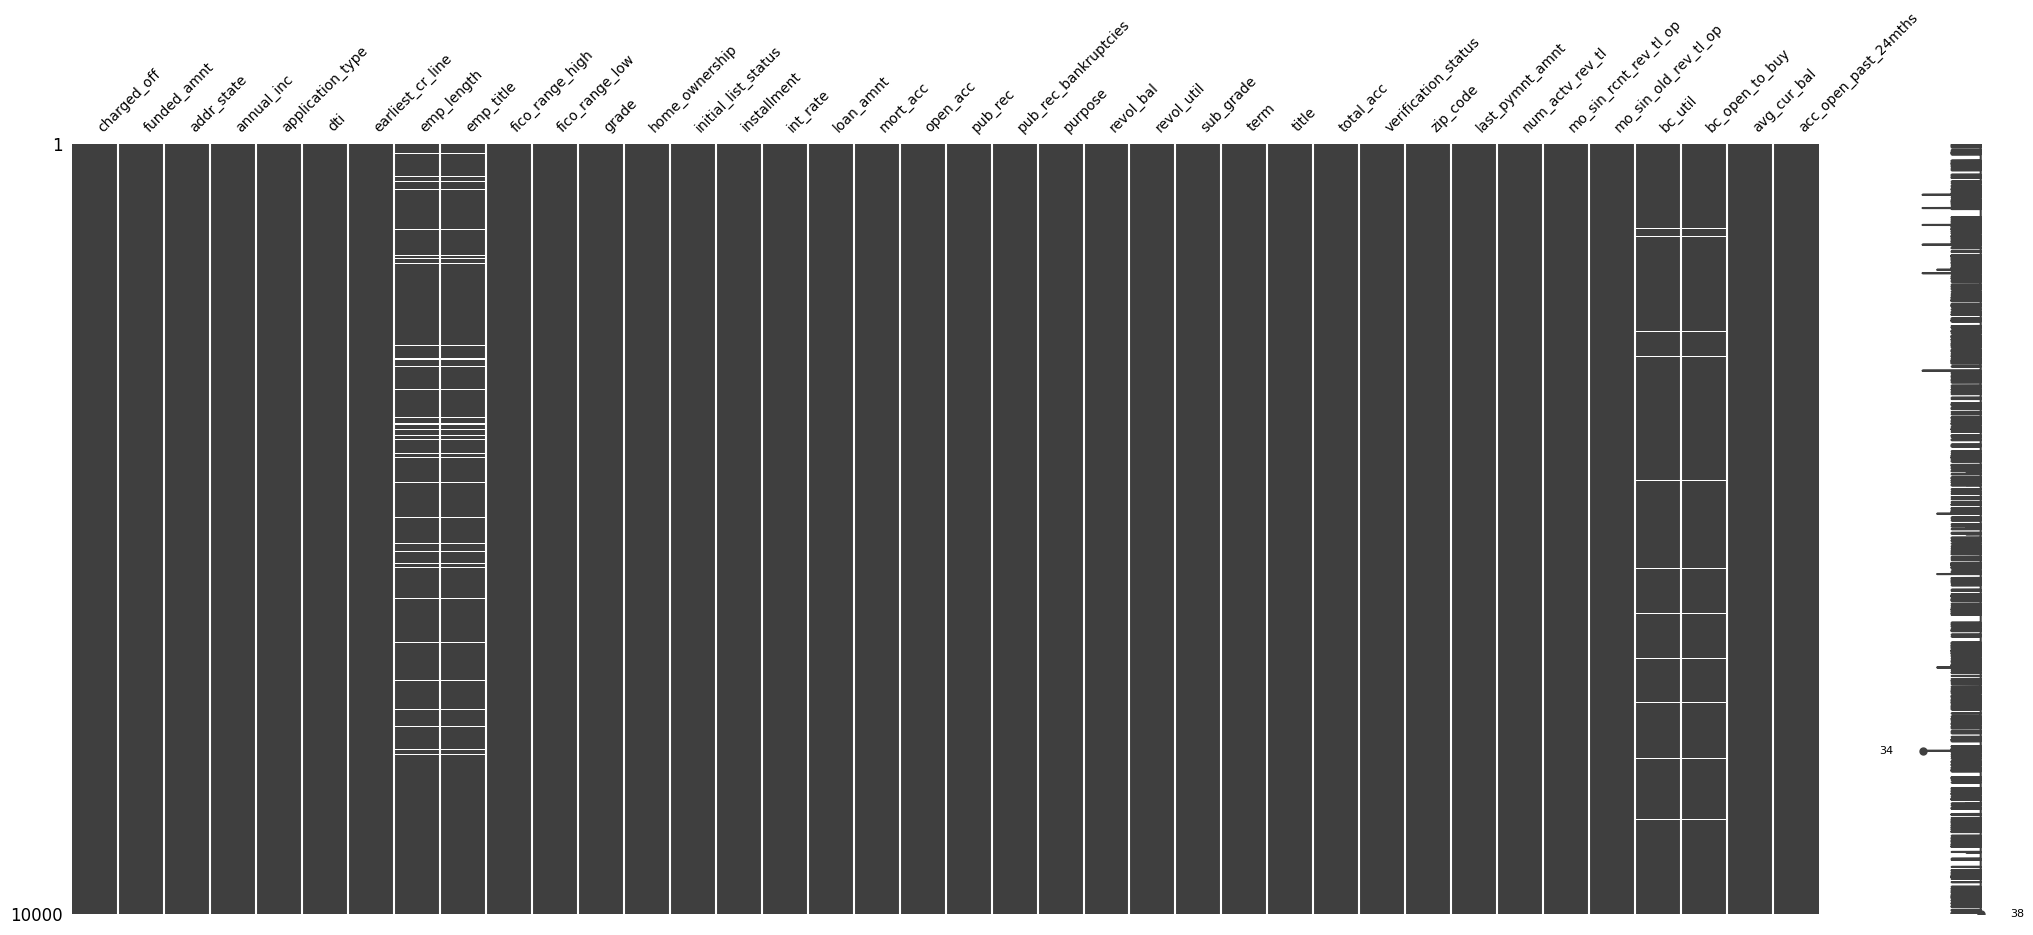

In [41]:
missings = auto.missing_values_analysis(train_data=all_train)

In [42]:
# Define the threshold (in this case, 90% or 0.9)
threshold = 90

# Get the columns that have a null percentage greater than the threshold
null_percentage = (all_train.isnull().sum() / len(all_train)) * 100
columns_to_drop = null_percentage[null_percentage > threshold].index
print(columns_to_drop)
# Drop the columns
a_train.drop(columns=columns_to_drop, inplace=True)
a_test.drop(columns=columns_to_drop, inplace=True)
a_val.drop(columns=columns_to_drop, inplace=True)
all_train.drop(columns=columns_to_drop, inplace=True)

Index([], dtype='object')


**`train_data` dataset summary (sample size: 10000)**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
acc_open_past_24mths,10000,26,,,4.6013,3.070941,0.0,2.0,4.0,6.0,42.0,float64,,,float,numeric,
addr_state,10000,46,CA,1437,,,,,,,,object,,,object,category,
annual_inc,10000,1443,,,73178.239042,47513.272586,4000.0,45000.0,62000.0,89000.0,900000.0,float64,,,float,numeric,
application_type,10000,1,Individual,10000,,,,,,,,object,,,object,category,
avg_cur_bal,10000,8039,,,13042.8875,15995.720627,0.0,2942.75,6934.0,18039.5,447433.0,float64,,,float,numeric,
bc_open_to_buy,9888,6859,,,8775.811792,14078.576055,0.0,1089.75,3739.5,10335.75,224525.0,float64,112,0.0112,float,numeric,
bc_util,9882,1048,,,63.870806,27.154072,0.0,44.1,68.15,87.4,141.2,float64,118,0.0118,float,numeric,
charged_off,10000,2,,,0.183,0.386686,0.0,0.0,0.0,0.0,1.0,uint8,,,int,category,
dti,10000,3260,,,18.532714,8.439463,0.0,12.2,17.985,24.54,39.98,float64,,,float,numeric,
earliest_cr_line,10000,493,Sep-2000,84,,,,,,,,object,,,object,category,datetime_as_object


**`test_data` dataset summary (sample size: 10000)**

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtypes,missing_count,missing_ratio,raw_type,variable_type,special_types
acc_open_past_24mths,10000,27,,,4.5811,3.058195,0.0,2.0,4.0,6.0,39.0,float64,,,float,numeric,
addr_state,10000,46,CA,1471,,,,,,,,object,,,object,category,
annual_inc,10000,1429,,,73930.624622,52583.752854,6900.0,45000.0,62000.0,89000.0,1250000.0,float64,,,float,numeric,
application_type,10000,1,Individual,10000,,,,,,,,object,,,object,category,
avg_cur_bal,10000,8044,,,13374.1735,17152.44231,0.0,2991.0,6978.5,18252.25,278317.0,float64,,,float,numeric,
bc_open_to_buy,9883,6893,,,8916.250936,13863.52323,0.0,1089.0,3775.0,10620.0,225313.0,float64,117,0.0117,float,numeric,
bc_util,9878,1060,,,63.712533,27.051444,0.0,43.9,67.6,87.5,188.8,float64,122,0.0122,float,numeric,
charged_off,10000,2,,,0.189,0.391528,0.0,0.0,0.0,0.0,1.0,uint8,,,int,category,
dti,10000,3284,,,18.385825,8.509072,0.0,11.99,17.83,24.41,39.99,float64,,,float,numeric,
earliest_cr_line,10000,498,Aug-2001,84,,,,,,,,object,,,object,category,datetime_as_object


### Feature Distance

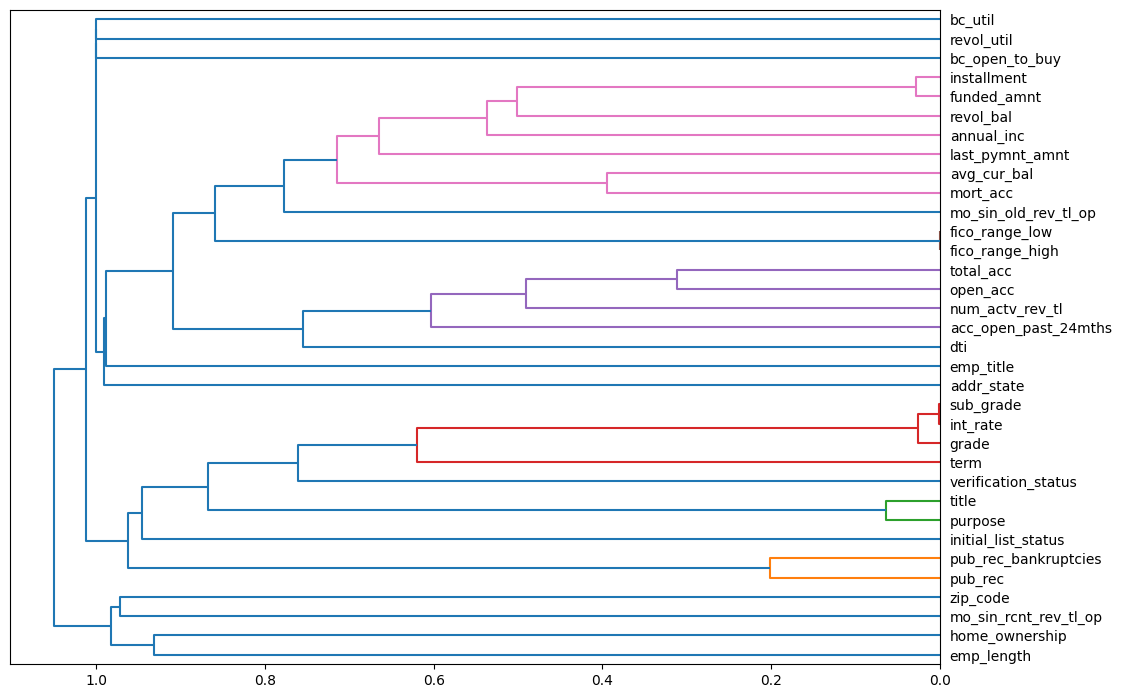

**The following feature groups are considered as near-duplicates**:

Distance threshold: <= `0.01`. Consider keeping only some of the columns within each group:

 - `fico_range_high`, `fico_range_low` - distance `0.00`
 - `int_rate`, `sub_grade` - distance `0.00`

Feature interaction between `fico_range_high`/`fico_range_low`

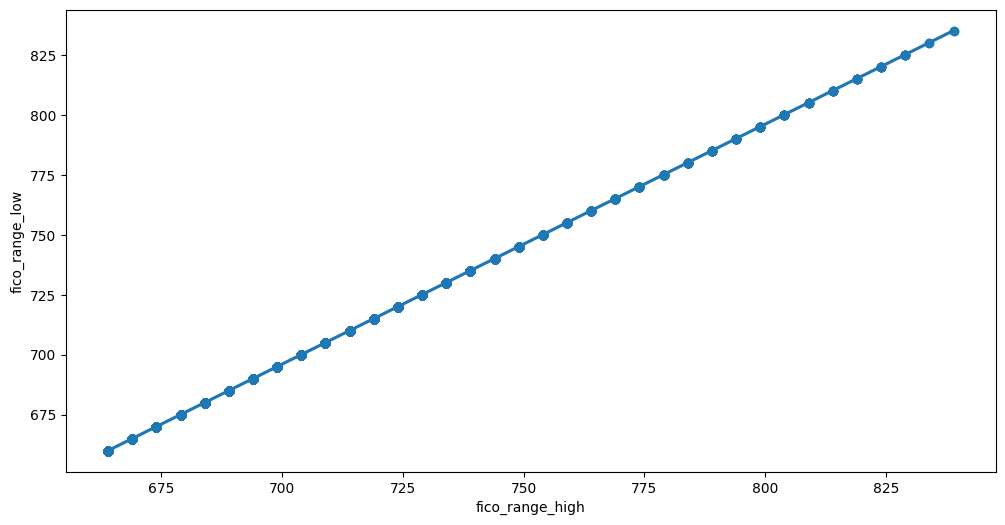

In [43]:
eda_overview = auto.dataset_overview(train_data=all_train, test_data=a_test, 
                      label='charged_off')

In [45]:
remove_columns_correlated = [
'total_pymnt', #total_pymnt_inv - distance 0.00
'debt_settlement_flag', #settlement_status - distance 0.00
'fico_range_high', #fico_range_low - distance 0.00
'last_fico_range_high', #last_fico_range_low - distance 0.00
'funded_amnt_inv', #loan_amnt - distance 0.00
'collection_recovery_fee', #recoveries - distance 0.00
'num_sats', #open_acc - distance 0.00
'int_rate', #sub_grade - distance 0.00
'num_actv_rev_tl',# num_rev_tl_bal_gt_0 
]
remove_columns_correlated = [f for f in all_train if f not in use_variables]

In [47]:
a_train = a_train.drop(columns=remove_columns_correlated)
a_val = a_val.drop(columns=remove_columns_correlated)
a_test = a_test.drop(columns=remove_columns_correlated)
all_train = all_train.drop(columns=remove_columns_correlated)


### Target EDA

## Target variable analysis

### Label Insights

 - Mild minority class imbalance detected - imbalance ratio is `22.40%`. Recommendations:
   - downsample majority class `0` to improve the balance
   - upweight downsampled class so that `sample_weight = original_weight x downsampling_factor`.[TabularPredictor](https://auto.gluon.ai/stable/api/autogluon.predictor.html#module-0) supports this via `sample_weight` parameter

,count,mean,std,min,25%,50%,75%,max,dtypes,unique,missing_count,missing_ratio,raw_type,special_types
charged_off,10000,0.183,0.386686,0.0,0.0,0.0,0.0,1.0,uint8,2,,,int,


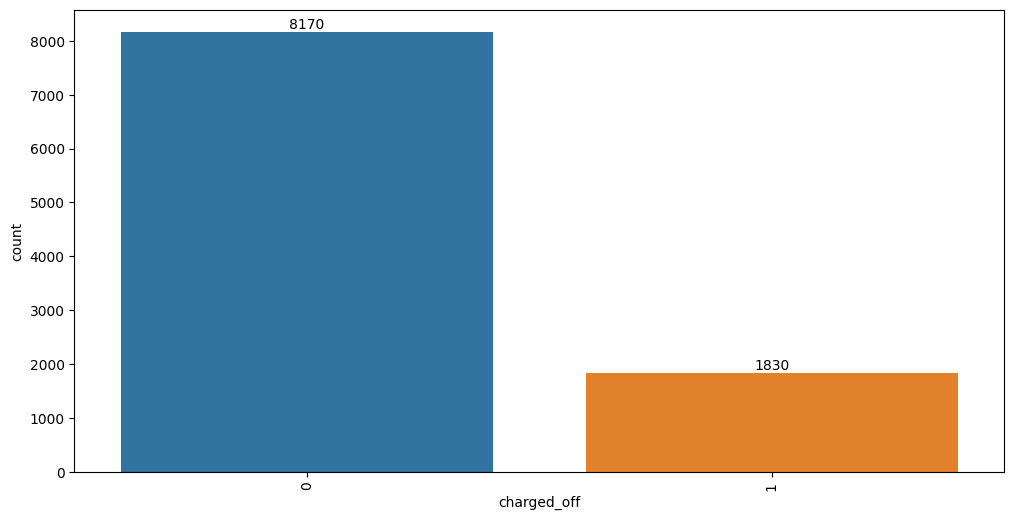

### Target variable correlations
 - ⚠️ no fields with absolute correlation greater than `0.5` found for target variable `charged_off`.

In [49]:
auto.target_analysis(train_data=all_train, label='charged_off')

### Covarianza entre X's

In [20]:
auto.covariate_shift_detection(train_data=all_train, test_data=a_test, label='charged_off')

We did not detect a substantial difference between the training and test X distributions.

In [21]:
auto.covariate_shift_detection(train_data=a_train, test_data=a_val, label='charged_off')

We did not detect a substantial difference between the training and test X distributions.

### Simple Model

No path specified. Models will be saved in: "AutogluonModels/ag-20240930_232934/"


### Model Prediction for charged_off

Using validation data for `Test` points

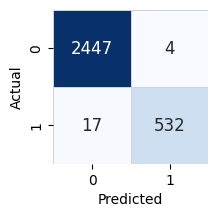

### Model Leaderboard

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT,0.993,0.997143,0.013844,0.009852,1.086592,0.013844,0.009852,1.086592,1,True,1


### Feature Importance for Trained Model

,importance,stddev,p_value,n,p99_high,p99_low
recoveries,0.057933,0.001479,5.099611e-08,5,0.060980,0.054887
last_pymnt_amnt,0.054600,0.001479,6.462984e-08,5,0.057646,0.051554
last_fico_range_low,0.041467,0.003525,6.203139e-06,5,0.048724,0.034210
last_pymnt_d,0.025067,0.001188,6.034176e-07,5,0.027513,0.022621
total_rec_prncp,0.015067,0.001479,1.101531e-05,5,0.018113,0.012020
term,0.009733,0.001362,4.485651e-05,5,0.012538,0.006929
installment,0.003067,0.000723,3.441407e-04,5,0.004555,0.001579
loan_amnt,0.002800,0.001261,3.833847e-03,5,0.005395,0.000205
total_rec_int,0.001067,0.000435,2.685221e-03,5,0.001962,0.000172
last_credit_pull_d,0.000933,0.000494,6.732538e-03,5,0.001951,-0.000085


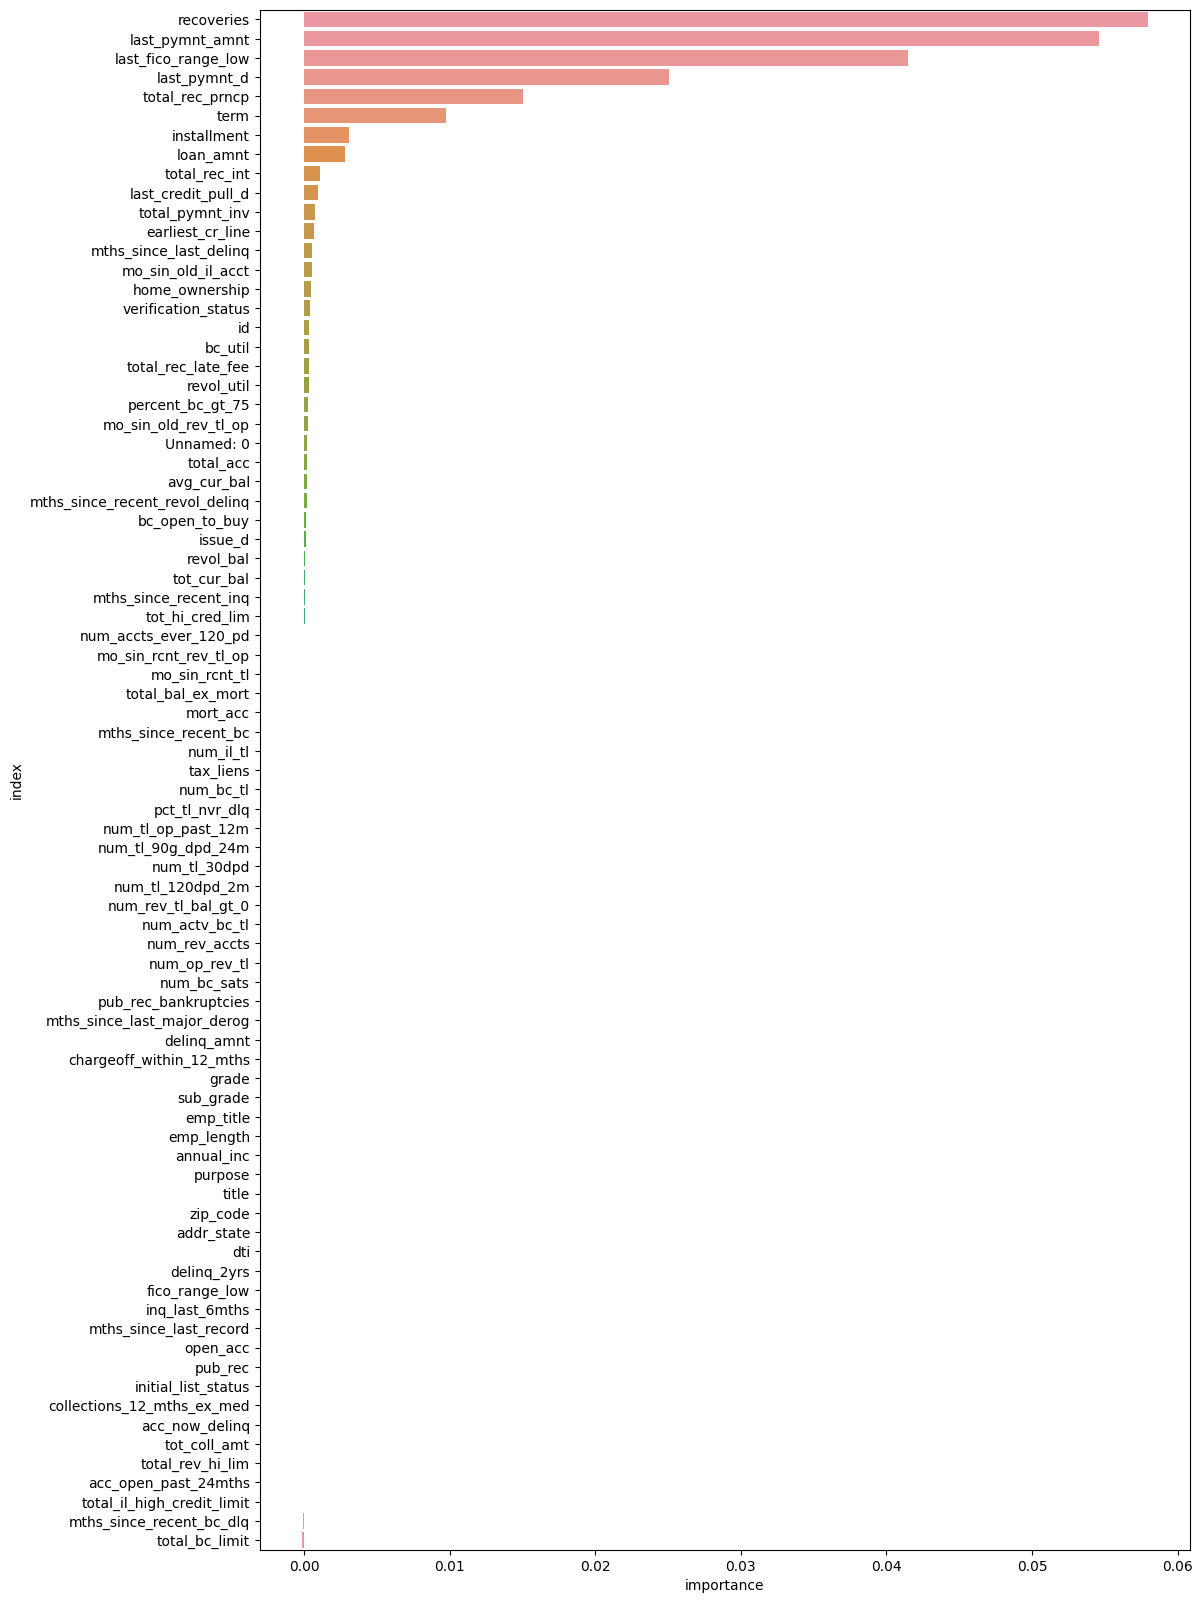

### Rows with the highest prediction error

Rows in this category worth inspecting for the causes of the error

,Unnamed: 0,id,loan_amnt,funded_amnt,term,installment,grade,sub_grade,emp_title,emp_length,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,charged_off,0,1,error
25421,23804,34722813,10000.0,10000.0,36 months,340.13,C,C3,administrative assistant,3 years,...,23425.0,14364.0,9900.0,6500.0,N,Cash,1,0.939358,0.060642,0.878716
68256,50892,30996120,8650.0,8650.0,36 months,308.36,D,D3,Manager,10+ years,...,474708.0,18763.0,2200.0,21708.0,N,Cash,1,0.873036,0.126964,0.746072
59403,29058,34392060,30000.0,30000.0,60 months,658.88,B,B4,Manager Managed Care Contracting,10+ years,...,219171.0,34739.0,20900.0,35801.0,N,Cash,1,0.870023,0.129977,0.740046
38733,80439,26260391,9225.0,9225.0,36 months,322.56,D,D1,None,None,...,151900.0,13665.0,49600.0,0.0,N,Cash,1,0.866473,0.133527,0.732946
14245,60135,29664395,25000.0,25000.0,36 months,779.84,A,A4,System Engineer,4 years,...,100554.0,38489.0,64700.0,23663.0,N,Cash,1,0.820950,0.179050,0.641900
22632,51941,30756075,9600.0,9600.0,36 months,306.04,B,B1,Account Representative,10+ years,...,51188.0,29539.0,5800.0,25688.0,N,Cash,1,0.740296,0.259704,0.480592
2838,94757,24144490,14000.0,14000.0,60 months,325.62,C,C3,None,None,...,352333.0,33990.0,5000.0,35260.0,N,Cash,1,0.727026,0.272974,0.454052
8221,9674,35979558,10000.0,10000.0,60 months,234.30,C,C4,Senior Office Assistant,2 years,...,96077.0,83498.0,35200.0,53277.0,N,Cash,1,0.662518,0.337482,0.325037
35237,62284,29254321,9000.0,9000.0,36 months,309.75,C,C4,sales associate,1 year,...,9110.0,6787.0,4400.0,3010.0,N,Cash,1,0.650934,0.349066,0.301868
61886,44670,31537866,10500.0,10500.0,36 months,351.22,B,B5,None,None,...,24536.0,16709.0,3000.0,19036.0,N,Cash,1,0.645110,0.354889,0.290221


### Rows with the least distance vs other class

Rows in this category are the closest to the decision boundary vs the other class and are good candidates for additional labeling

,Unnamed: 0,id,loan_amnt,funded_amnt,term,installment,grade,sub_grade,emp_title,emp_length,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,charged_off,0,1,error
53426,21889,34593341,10200.0,10200.0,60 months,254.27,D,D4,Technical Writer,10+ years,...,271683.0,77799.0,4200.0,89466.0,N,Cash,0,0.495228,0.504772,0.009544
28593,16617,35338360,8850.0,8850.0,36 months,322.36,E,E1,None,None,...,119209.0,95698.0,4200.0,115009.0,N,Cash,1,0.534083,0.465917,0.068167
53117,88257,24865158,8000.0,8000.0,36 months,264.46,B,B4,nanny,10+ years,...,35248.0,24083.0,13000.0,16248.0,N,Cash,0,0.457252,0.542748,0.085496
11496,46215,31567205,12600.0,12600.0,36 months,461.81,E,E1,Account Manager,< 1 year,...,235931.0,37840.0,16400.0,31500.0,N,Cash,0,0.443449,0.556551,0.113102
57760,53491,30435685,20000.0,20000.0,60 months,503.21,D,D4,None,None,...,479797.0,119672.0,8800.0,111926.0,N,Cash,0,0.433428,0.566572,0.133145
57405,96281,21100461,18900.0,18900.0,60 months,511.21,E,E4,Manager,8 years,...,51898.0,42164.0,6300.0,43598.0,N,Cash,1,0.568287,0.431713,0.136574
59768,53781,30575483,25000.0,25000.0,36 months,773.30,A,A3,Controller,< 1 year,...,502450.0,36259.0,55400.0,0.0,N,Cash,1,0.589030,0.410970,0.178060
35151,9454,36039615,28000.0,28000.0,36 months,852.20,A,A1,Chief Engineer,< 1 year,...,326625.0,14979.0,67900.0,0.0,N,Cash,1,0.599744,0.400256,0.199487
43412,17195,30335222,35000.0,35000.0,36 months,1238.98,D,D3,Quality Trainer,10+ years,...,94907.0,71599.0,4600.0,88107.0,N,Cash,1,0.607968,0.392032,0.215935
17397,1426,37670606,8975.0,8975.0,36 months,320.61,D,D4,Owner,3 years,...,45051.0,27447.0,4000.0,41051.0,N,Cash,1,0.626585,0.373415,0.253170


In [22]:
state = auto.quick_fit(
    all_train, 
    'charged_off', 
    return_state=True,
    show_feature_importance_barplots=True
)

,Unnamed: 0,id,loan_amnt,funded_amnt,term,installment,grade,sub_grade,emp_title,emp_length,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,charged_off,0,1,error
25421,23804,34722813,10000.0,10000.0,36 months,340.13,C,C3,administrative assistant,3 years,...,23425.0,14364.0,9900.0,6500.0,N,Cash,1,0.939358,0.060642,0.878716


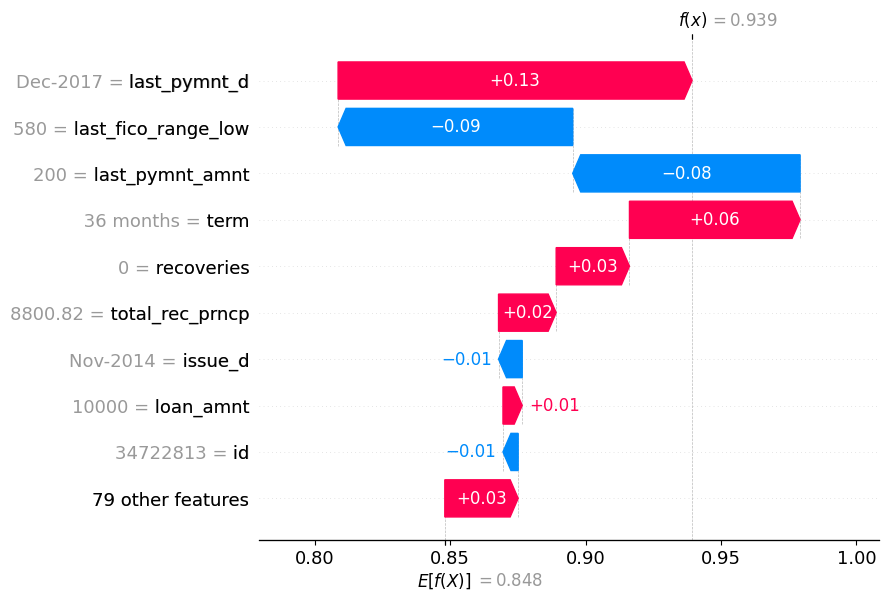

In [23]:
auto.explain_rows(
    train_data=all_train,
    model=state.model,
    display_rows=True,
    plot='waterfall',
    rows=state.model_evaluation.highest_error[:1]
)

## Autogluon Entrenamiento

### Metricas

![Alt text](image.png)

### Pesos

![Alt text](image-1.png)

In [24]:
save_path = 'AutogluonModels'


predictor = TabularPredictor(label='charged_off', path=save_path, 
                             problem_type='binary',
                             eval_metric='log_loss', # Es mas rapido de entrenar
                             sample_weight='balance_weight' # Pesos a a la funcion de perdida
                             )

### Fit

![Alt text](image-2.png)

![Alt text](image-4.png)

![Alt text](image-3.png)

#### Validation

In [25]:
predictor_val = TabularPredictor(label='charged_off', path=os.path.join(save_path,'validation'), 
                             problem_type='binary',
                             eval_metric='log_loss', # Es mas rapido de entrenar, luego evaluamos otras metricas
                             sample_weight='balance_weight', # Pesos a a la funcion de perdida
                             ).fit(
                                 train_data = a_train,
                                 time_limit = None, # Seconds o None para no poner limite
                                 presets='medium_quality',
                                 num_cpus = 8,
                                 tuning_data = a_val,
                                 hyperparameters = {
                                #'NN_TORCH': {},
                                'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge'],
                                #'CAT': {},
                                #'XGB': {},
                                #'FASTAI': {},
                                'RF': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
                                       {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}},
                                       {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
                                # 'XT': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
                                #        {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, 
                                #        {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
                                'KNN': [{'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}},
                                        {'weights': 'distance', 'ag_args': {'name_suffix': 'Dist'}}],
                            }
                             )

Presets specified: ['medium_quality']
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Using predefined sample weighting strategy: balance_weight. Evaluation metrics will ignore sample weights, specify weight_evaluation=True to instead report weighted metrics.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/validation/"
AutoGluon Version:  0.8.3
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #202405300957~1721174657~22.04~abb7c06 SMP PREEMPT_DYNAMIC Wed J
Disk Space Avail:   818.97 GB / 911.11 GB (89.9%)
Train Data Rows:    55128
Train Data Columns: 88
Tuning Data Rows:    13782
Tuning Data Columns: 88
Label Column: charged_off
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Assigning sample weights to balance d

In [26]:
predictor_val.feature_importance(a_val)

These features in provided data are not utilized by the predictor and will be ignored: ['funded_amnt', 'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'policy_code', 'application_type', 'hardship_flag', 'disbursement_method']
Computing feature importance via permutation shuffling for 80 features using 5000 rows with 5 shuffle sets...


	112.09s	= Expected runtime (22.42s per shuffle set)
	63.36s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
recoveries,0.508177,0.026734,9.156806e-07,5,0.563222,0.453133
total_rec_prncp,0.421037,0.027609,2.206129e-06,5,0.477885,0.364189
loan_amnt,0.179667,0.006049,1.539207e-07,5,0.192121,0.167213
last_pymnt_amnt,0.100974,0.009455,9.118322e-06,5,0.120441,0.081506
last_fico_range_low,0.020299,0.003470,9.862131e-05,5,0.027444,0.013154
...,...,...,...,...,...,...
mo_sin_old_il_acct,-0.000026,0.000138,6.537220e-01,5,0.000258,-0.000310
num_bc_tl,-0.000030,0.000024,9.753100e-01,5,0.000019,-0.000079
mths_since_recent_bc,-0.000040,0.000050,9.252923e-01,5,0.000063,-0.000143
annual_inc,-0.000046,0.000050,9.453230e-01,5,0.000057,-0.000148


In [27]:
predictor_val.leaderboard(a_val, extra_metrics=['mcc', 'balanced_accuracy', 'f1', 'precision', 'roc_auc'])

                 model  score_test       mcc  balanced_accuracy        f1  precision   roc_auc  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2   -0.003204  0.996666           0.997292  0.997285   1.000000  0.999989  -0.003211        0.402998       0.359124  26.203522                 0.005753                0.000990           0.683259            2       True          8
1             LightGBM   -0.003474  0.997142           0.997679  0.997674   1.000000  0.999990  -0.003474        0.118474       0.117619   7.964812                 0.118474                0.117619           7.964812            1       True          4
2        LightGBMLarge   -0.006175  0.993564           0.995670  0.994762   0.997665  0.999959  -0.006175        0.104391       0.086395   9.025173                 0.104391                0.086395           9.025173            1       True        

,model,score_test,mcc,balanced_accuracy,f1,precision,roc_auc,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-0.003204,0.996666,0.997292,0.997285,1.000000,0.999989,-0.003211,0.402998,0.359124,26.203522,0.005753,0.000990,0.683259,2,True,8
1,LightGBM,-0.003474,0.997142,0.997679,0.997674,1.000000,0.999990,-0.003474,0.118474,0.117619,7.964812,0.118474,0.117619,7.964812,1,True,4
2,LightGBMLarge,-0.006175,0.993564,0.995670,0.994762,0.997665,0.999959,-0.006175,0.104391,0.086395,9.025173,0.104391,0.086395,9.025173,1,True,7
3,LightGBMXT,-0.007740,0.991656,0.994867,0.993213,0.995723,0.999934,-0.007740,0.174379,0.154120,8.530278,0.174379,0.154120,8.530278,1,True,3
4,RandomForestEntr,-0.031720,0.984485,0.988023,0.987287,0.998418,0.999854,-0.031720,0.138937,0.112184,12.244743,0.138937,0.112184,12.244743,1,True,6
5,RandomForestGini,-0.033125,0.984248,0.987680,0.987084,0.998812,0.999845,-0.033125,0.157257,0.124282,12.536286,0.157257,0.124282,12.536286,1,True,5
6,KNeighborsUnif,-0.808678,0.536093,0.741099,0.606127,0.697733,0.828567,-0.808678,2.016965,2.012233,0.101611,2.016965,2.012233,0.101611,1,True,1
7,KNeighborsDist,-1.086103,0.519058,0.739118,0.596716,0.664924,0.812396,-1.086103,1.978939,2.237199,0.097908,1.978939,2.237199,0.097908,1,True,2


In [28]:
predictor_val.leaderboard(a_test, extra_metrics=['mcc', 'balanced_accuracy', 'f1', 'precision', 'roc_auc'])

                 model  score_test       mcc  balanced_accuracy        f1  precision   roc_auc  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0             LightGBM   -0.003851  0.996570           0.997214  0.997207   1.000000  0.999990  -0.003474        0.161865       0.117619   7.964812                 0.161865                0.117619           7.964812            1       True          4
1  WeightedEnsemble_L2   -0.003930  0.996379           0.997060  0.997051   1.000000  0.999984  -0.003211        0.557148       0.359124  26.203522                 0.006221                0.000990           0.683259            2       True          8
2        LightGBMLarge   -0.007592  0.993325           0.995417  0.994566   0.997819  0.999914  -0.006175        0.174533       0.086395   9.025173                 0.174533                0.086395           9.025173            1       True        

,model,score_test,mcc,balanced_accuracy,f1,precision,roc_auc,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM,-0.003851,0.996570,0.997214,0.997207,1.000000,0.999990,-0.003474,0.161865,0.117619,7.964812,0.161865,0.117619,7.964812,1,True,4
1,WeightedEnsemble_L2,-0.003930,0.996379,0.997060,0.997051,1.000000,0.999984,-0.003211,0.557148,0.359124,26.203522,0.006221,0.000990,0.683259,2,True,8
2,LightGBMLarge,-0.007592,0.993325,0.995417,0.994566,0.997819,0.999914,-0.006175,0.174533,0.086395,9.025173,0.174533,0.086395,9.025173,1,True,7
3,LightGBMXT,-0.008867,0.990082,0.994215,0.991935,0.994094,0.999754,-0.007740,0.214530,0.154120,8.530278,0.214530,0.154120,8.530278,1,True,3
4,RandomForestEntr,-0.031301,0.983385,0.987013,0.986370,0.998731,0.999710,-0.031720,0.162056,0.112184,12.244743,0.162056,0.112184,12.244743,1,True,6
5,RandomForestGini,-0.032646,0.983202,0.986382,0.986194,1.000000,0.999815,-0.033125,0.177444,0.124282,12.536286,0.177444,0.124282,12.536286,1,True,5
6,KNeighborsUnif,-0.853728,0.532264,0.744557,0.607118,0.678913,0.824049,-0.808678,2.421715,2.012233,0.101611,2.421715,2.012233,0.101611,1,True,1
7,KNeighborsDist,-1.158855,0.512915,0.741758,0.595709,0.643781,0.805766,-1.086103,2.418977,2.237199,0.097908,2.418977,2.237199,0.097908,1,True,2


In [29]:
predicted_prob_val = predictor_val.predict_proba(a_test)
summary_val = predictor_val.evaluate_predictions(a_test['charged_off'], predicted_prob_val, auxiliary_metrics=True, detailed_report=True)
summary_val

Evaluation: log_loss on test data: -0.003929993418091114
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "log_loss": -0.003929993418091114,
    "accuracy": 0.9988971441838866,
    "balanced_accuracy": 0.9970597338285361,
    "mcc": 0.9963793683441151,
    "roc_auc": 0.9999837919019964,
    "f1": 0.997051063169331,
    "precision": 1.0,
    "recall": 0.9941194676570722
}
Detailed (per-class) classification report:
{
    "0": {
        "precision": 0.998644406392694,
        "recall": 1.0,
        "f1-score": 0.9993217434762431,
        "support": 13997.0
    },
    "1": {
        "precision": 1.0,
        "recall": 0.9941194676570722,
        "f1-score": 0.997051063169331,
        "support": 3231.0
    },
    "accuracy": 0.9988971441838866,
    "macro avg": {
        "precision": 0.999322203196347,
        "recall": 0.9970597338285361,
        "f1-score": 0.9981864033227871,
        "support": 

{'log_loss': -0.003929993418091114,
 'accuracy': 0.9988971441838866,
 'balanced_accuracy': 0.9970597338285361,
 'mcc': 0.9963793683441151,
 'roc_auc': 0.9999837919019964,
 'f1': 0.997051063169331,
 'precision': 1.0,
 'recall': 0.9941194676570722,
 'confusion_matrix':        0     1
 0  13997     0
 1     19  3212,
 'classification_report': {'0': {'precision': 0.998644406392694,
   'recall': 1.0,
   'f1-score': 0.9993217434762431,
   'support': 13997.0},
  '1': {'precision': 1.0,
   'recall': 0.9941194676570722,
   'f1-score': 0.997051063169331,
   'support': 3231.0},
  'accuracy': 0.9988971441838866,
  'macro avg': {'precision': 0.999322203196347,
   'recall': 0.9970597338285361,
   'f1-score': 0.9981864033227871,
   'support': 17228.0},
  'weighted avg': {'precision': 0.9988986392081809,
   'recall': 0.9988971441838866,
   'f1-score': 0.9988958920673952,
   'support': 17228.0}}}

### Validation Good

In [30]:
predictor_good = TabularPredictor(label='charged_off', path=os.path.join(save_path,'good_quality'), 
                             problem_type='binary',
                             eval_metric='log_loss', # Es mas rapido de entrenar, luego evaluamos otras metricas
                             sample_weight='balance_weight', # Pesos a a la funcion de perdida
                             ).fit(
                                 train_data = all_train,
                                 time_limit = None, # Seconds o None para no poner limite
                                 presets='good_quality',
                                 num_cpus = 8,
                                 #tuning_data = a_val, # Sin val para good_quality
                                 hyperparameters = {
                                #'NN_TORCH': {},
                                'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge'],
                                #'CAT': {},
                                #'XGB': {},
                                #'FASTAI': {},
                                # 'RF': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
                                #        {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}},
                                #        {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
                                # 'XT': [{'criterion': 'gini', 'ag_args': {'name_suffix': 'Gini', 'problem_types': ['binary', 'multiclass']}},
                                #        {'criterion': 'entropy', 'ag_args': {'name_suffix': 'Entr', 'problem_types': ['binary', 'multiclass']}}, 
                                #        {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression', 'quantile']}}],
                                # 'KNN': [{'weights': 'uniform', 'ag_args': {'name_suffix': 'Unif'}},
                                #         {'weights': 'distance', 'ag_args': {'name_suffix': 'Dist'}}],
                            }
                             )

Presets specified: ['good_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Using predefined sample weighting strategy: balance_weight. Evaluation metrics will ignore sample weights, specify weight_evaluation=True to instead report weighted metrics.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/good_quality/"
AutoGluon Version:  0.8.3
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #202405300957~1721174657~22.04~abb7c06 SMP PREEMPT_DYNAMIC Wed J
Disk Space Avail:   818.79 GB / 911.11 GB (89.9%)
Train Data Rows:    68910
Train Data Columns: 88
Label Column: charged_off
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 =

In [31]:
predictor_good.feature_importance(all_train)

These features in provided data are not utilized by the predictor and will be ignored: ['funded_amnt', 'pymnt_plan', 'out_prncp', 'out_prncp_inv', 'policy_code', 'application_type', 'hardship_flag', 'disbursement_method']
Computing feature importance via permutation shuffling for 80 features using 5000 rows with 5 shuffle sets...


	127.86s	= Expected runtime (25.57s per shuffle set)
	83.48s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
total_rec_prncp,5.128885e-01,2.415618e-02,5.887343e-07,5,5.626264e-01,4.631505e-01
recoveries,4.133206e-01,2.547359e-02,1.722651e-06,5,4.657710e-01,3.608701e-01
loan_amnt,2.249514e-01,3.984981e-03,1.181272e-08,5,2.331565e-01,2.167463e-01
last_pymnt_amnt,8.842710e-02,6.987835e-03,4.640905e-06,5,1.028152e-01,7.403906e-02
last_fico_range_low,1.059726e-02,3.487023e-03,1.224595e-03,5,1.777709e-02,3.417434e-03
...,...,...,...,...,...,...
collections_12_mths_ex_med,9.143839e-09,1.242231e-08,8.756176e-02,5,3.472154e-08,-1.643386e-08
num_tl_90g_dpd_24m,8.672967e-09,1.072659e-08,7.244451e-02,5,3.075916e-08,-1.341323e-08
num_tl_30dpd,2.449717e-09,5.125429e-09,1.726974e-01,5,1.300305e-08,-8.103611e-09
acc_now_delinq,0.000000e+00,0.000000e+00,5.000000e-01,5,0.000000e+00,0.000000e+00


In [32]:
predictor_good.leaderboard(all_train, extra_metrics=['mcc', 'balanced_accuracy', 'f1', 'precision', 'roc_auc'])

                       model  score_test  mcc  balanced_accuracy   f1  precision  roc_auc  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       LightGBM_BAG_L1_FULL   -0.000003  1.0                1.0  1.0        1.0      1.0        NaN        0.935623            NaN    6.093878                 0.935623                     NaN           6.093878            1       True          6
1   WeightedEnsemble_L2_FULL   -0.000081  1.0                1.0  1.0        1.0      1.0        NaN        2.444145            NaN   16.851307                 0.012037                     NaN           1.120299            2       True          8
2     LightGBMXT_BAG_L1_FULL   -0.000831  1.0                1.0  1.0        1.0      1.0        NaN        1.040449            NaN    5.195302                 1.040449                     NaN           5.195302            1       True          5
3  LightGBML

,model,score_test,mcc,balanced_accuracy,f1,precision,roc_auc,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBM_BAG_L1_FULL,-0.000003,1.0,1.0,1.0,1.0,1.0,NaN,0.935623,NaN,6.093878,0.935623,NaN,6.093878,1,True,6
1,WeightedEnsemble_L2_FULL,-0.000081,1.0,1.0,1.0,1.0,1.0,NaN,2.444145,NaN,16.851307,0.012037,NaN,1.120299,2,True,8
2,LightGBMXT_BAG_L1_FULL,-0.000831,1.0,1.0,1.0,1.0,1.0,NaN,1.040449,NaN,5.195302,1.040449,NaN,5.195302,1,True,5
3,LightGBMLarge_BAG_L1_FULL,-0.001128,1.0,1.0,1.0,1.0,1.0,NaN,0.456036,NaN,4.441828,0.456036,NaN,4.441828,1,True,7
4,WeightedEnsemble_L2,NaN,NaN,NaN,NaN,NaN,NaN,-0.004530,NaN,9.846834,116.877104,NaN,0.002517,1.120299,2,False,4
5,LightGBM_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,-0.004847,NaN,3.932148,44.130018,NaN,3.932148,44.130018,1,False,2
6,LightGBMLarge_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,-0.009324,NaN,1.927245,28.575431,NaN,1.927245,28.575431,1,False,3
7,LightGBMXT_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,-0.009840,NaN,3.984924,43.051355,NaN,3.984924,43.051355,1,False,1


In [33]:
predictor_good.leaderboard(a_test, extra_metrics=['mcc', 'balanced_accuracy', 'f1', 'precision', 'roc_auc'])

                       model  score_test       mcc  balanced_accuracy        f1  precision   roc_auc  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2_FULL   -0.003505  0.996951           0.997524  0.997518   1.000000  0.999980        NaN        0.638098            NaN   16.851307                 0.005544                     NaN           1.120299            2       True          8
1       LightGBM_BAG_L1_FULL   -0.003652  0.996951           0.997524  0.997518   1.000000  0.999990        NaN        0.251619            NaN    6.093878                 0.251619                     NaN           6.093878            1       True          6
2  LightGBMLarge_BAG_L1_FULL   -0.007496  0.993325           0.995536  0.994568   0.997509  0.999896        NaN        0.125978            NaN    4.441828                 0.125978                     NaN           4.441828    

,model,score_test,mcc,balanced_accuracy,f1,precision,roc_auc,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2_FULL,-0.003505,0.996951,0.997524,0.997518,1.000000,0.999980,NaN,0.638098,NaN,16.851307,0.005544,NaN,1.120299,2,True,8
1,LightGBM_BAG_L1_FULL,-0.003652,0.996951,0.997524,0.997518,1.000000,0.999990,NaN,0.251619,NaN,6.093878,0.251619,NaN,6.093878,1,True,6
2,LightGBMLarge_BAG_L1_FULL,-0.007496,0.993325,0.995536,0.994568,0.997509,0.999896,NaN,0.125978,NaN,4.441828,0.125978,NaN,4.441828,1,True,7
3,LightGBMXT_BAG_L1_FULL,-0.008987,0.989710,0.994619,0.991638,0.992253,0.999752,NaN,0.254957,NaN,5.195302,0.254957,NaN,5.195302,1,True,5
4,WeightedEnsemble_L2,NaN,NaN,NaN,NaN,NaN,NaN,-0.004530,NaN,9.846834,116.877104,NaN,0.002517,1.120299,2,False,4
5,LightGBM_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,-0.004847,NaN,3.932148,44.130018,NaN,3.932148,44.130018,1,False,2
6,LightGBMLarge_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,-0.009324,NaN,1.927245,28.575431,NaN,1.927245,28.575431,1,False,3
7,LightGBMXT_BAG_L1,NaN,NaN,NaN,NaN,NaN,NaN,-0.009840,NaN,3.984924,43.051355,NaN,3.984924,43.051355,1,False,1


In [34]:
predicted_prob_good = predictor_good.predict_proba(a_test)
summary_good = predictor_good.evaluate_predictions(a_test['charged_off'], predicted_prob_val, auxiliary_metrics=True, detailed_report=True)
summary_good

Evaluation: log_loss on test data: -0.003929993418091114
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "log_loss": -0.003929993418091114,
    "accuracy": 0.9988971441838866,
    "balanced_accuracy": 0.9970597338285361,
    "mcc": 0.9963793683441151,
    "roc_auc": 0.9999837919019964,
    "f1": 0.997051063169331,
    "precision": 1.0,
    "recall": 0.9941194676570722
}
Detailed (per-class) classification report:
{
    "0": {
        "precision": 0.998644406392694,
        "recall": 1.0,
        "f1-score": 0.9993217434762431,
        "support": 13997.0
    },
    "1": {
        "precision": 1.0,
        "recall": 0.9941194676570722,
        "f1-score": 0.997051063169331,
        "support": 3231.0
    },
    "accuracy": 0.9988971441838866,
    "macro avg": {
        "precision": 0.999322203196347,
        "recall": 0.9970597338285361,
        "f1-score": 0.9981864033227871,
        "support": 

{'log_loss': -0.003929993418091114,
 'accuracy': 0.9988971441838866,
 'balanced_accuracy': 0.9970597338285361,
 'mcc': 0.9963793683441151,
 'roc_auc': 0.9999837919019964,
 'f1': 0.997051063169331,
 'precision': 1.0,
 'recall': 0.9941194676570722,
 'confusion_matrix':        0     1
 0  13997     0
 1     19  3212,
 'classification_report': {'0': {'precision': 0.998644406392694,
   'recall': 1.0,
   'f1-score': 0.9993217434762431,
   'support': 13997.0},
  '1': {'precision': 1.0,
   'recall': 0.9941194676570722,
   'f1-score': 0.997051063169331,
   'support': 3231.0},
  'accuracy': 0.9988971441838866,
  'macro avg': {'precision': 0.999322203196347,
   'recall': 0.9970597338285361,
   'f1-score': 0.9981864033227871,
   'support': 17228.0},
  'weighted avg': {'precision': 0.9988986392081809,
   'recall': 0.9988971441838866,
   'f1-score': 0.9988958920673952,
   'support': 17228.0}}}